# Usando Flax

* Es una librería end-to-end contruída sobre Jax.
* Está enfocada mucho en investigación.
* Flax soporta varias APIs para diseñar redes neuronales. Las oficiales que tienen son:
  * Haiku
  * Linen
  * NNX (el más nuevo)

In [1]:
# Herramienta de visualización
!pip install penzai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 6.5 MB/s eta 0:00:00


In [14]:
from flax import nnx
import jax
import jax.numpy as jnp
import optax
from jax import lax

In [5]:
# Load data
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

X, y = load_breast_cancer(return_X_y=True)
scaler = StandardScaler()
scaler.fit(X)
X_norm = scaler.transform(X)
X_jax = jnp.array(X_norm)
y_jax = jnp.array(y)

In [17]:
y_jax

Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

Vamos a usar NNX. Algunos puntos importantes a tomar en cuenta:
* En NNX todo tiene que ser explicítamente definido.
* Los parámetros se mantienen en el init por el módulo creado.
* El estado del RNG lo define el usuario.
* Toda la información de tamaños se tiene que definir en la inicialización. En Haiku y Linen no es necesario.


In [6]:
# Creamos una MLP
class MLP(nnx.Module):
  def __init__(self, in_features:int, out_features:int, hidden_layers, rngs):
    self.layers = []
    input_layer_size = in_features
    for output_layer_size in hidden_layers:
      self.layers.append(nnx.Linear(input_layer_size, output_layer_size, rngs=rngs))
      input_layer_size = output_layer_size

  def __call__(self, x):
    for layer in self.layers[:-1]:
      x = layer(x)
      #x = jax.nn.relu(x)
      x = nnx.relu(x)

    x = self.layers[-1](x)
    return x

In [7]:
# Instanciar modelo
model = MLP(X_jax.shape[1], 1, (4,4,1), nnx.Rngs(0))

In [8]:
# Visualizar modelo
nnx.display(model)

AttributeError: module 'penzai.pz' has no attribute 'Layer'

In [9]:
# Probar modelo
yp = model(X_jax[0,:])
nnx.display(yp)

In [10]:
# Creamos optimizador
learning_rate = 0.001
momentum = 0.9

# Configuramos el optimizador
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))

# configuramos el objeto para darle seguimiento a las métricas
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)
nnx.display(optimizer)

AttributeError: module 'penzai.pz' has no attribute 'Layer'

In [18]:
# Hay que definir la función de pérdida
def loss_fn(model: MLP, batch_x, batch_y):
  logits = model(batch_x)
  #loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_y).mean()
  loss = optax.sigmoid_binary_cross_entropy(logits=logits, labels=batch_y).mean()
  return loss, logits

In [19]:
# Definimos el paso de entrenamiento, es decir, que haremos en cada época
@nnx.jit
def train_step(model: MLP, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch_x, batch_y):
  """Train for a single step."""
  # calculamos el gradiente del error
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)

  # Aplicamos el gradiente del error
  (loss, logits), grads = grad_fn(model, batch_x, batch_y)

  # calculamos las metricas
  metrics.update(loss=loss, logits=logits, labels=batch_y)  # inplace updates

  # Aplicamos el gradiente en los pesos
  optimizer.update(grads)  # inplace updates

In [20]:
# definimos el paso de evaluación
@nnx.jit
def eval_step(model: MLP, metrics: nnx.MultiMetric, batch_x, batch_y):
  loss, logits = loss_fn(model, batch_x, batch_y)
  metrics.update(loss=loss, logits=logits, labels=batch_y)  # inplace updates

In [24]:
metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

batch_size = 16
epochs = 10
n_batches = int(jnp.floor(y_jax.shape[0]/batch_size))
eval_every = 1
for epoch in range(epochs):
  for step in range(n_batches-1):
    i0 = step*batch_size
    i1 = (step+1)*batch_size
    #print(i0)
    #print(i1)
    X_p = lax.slice(X, (i0,0), (i1, X.shape[1]))
    y_p = lax.slice(y, (i0,), (i1,))

    # Run the optimization for one step and make a stateful update to the following:
    # - the train state's model parameters
    # - the optimizer state
    # - the training loss and accuracy batch metrics
    train_step(model, optimizer, metrics, X_p, y_p)

    if step > 0 and (step % eval_every == 0 or step == n_batches - 1):  # one training epoch has passed
      # Log training metrics
      for metric, value in metrics.compute().items():  # compute metrics
        metrics_history[f'train_{metric}'].append(value)  # record metrics
      metrics.reset()  # reset metrics for test set

      # Compute metrics on the test set after each training epoch
      #for test_batch in test_ds.as_numpy_iterator():
      #  eval_step(model, metrics, test_batch)

      # Log test metrics
      #for metric, value in metrics.compute().items():
      #  metrics_history[f'test_{metric}'].append(value)
      #metrics.reset()  # reset metrics for next training epoch

      print(
        f"[train] step: {step}, "
        f"loss: {metrics_history['train_loss'][-1]}, "
        f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
      )
      #print(
      #  f"[test] step: {step}, "
      #  f"loss: {metrics_history['test_loss'][-1]}, "
      #  f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
      #)

[train] step: 1, loss: 0.6921688318252563, accuracy: 52.499996185302734
[train] step: 2, loss: 0.6381298899650574, accuracy: 87.5
[train] step: 3, loss: 0.7058315277099609, accuracy: 31.25
[train] step: 4, loss: 0.6936702132225037, accuracy: 50.0
[train] step: 5, loss: 0.6936677098274231, accuracy: 50.0
[train] step: 6, loss: 0.7097707390785217, accuracy: 25.0
[train] step: 7, loss: 0.7094681859016418, accuracy: 43.75
[train] step: 8, loss: 0.6976667046546936, accuracy: 43.75
[train] step: 9, loss: 0.7176371812820435, accuracy: 12.5
[train] step: 10, loss: 0.697638750076294, accuracy: 43.75
[train] step: 11, loss: 0.6976231336593628, accuracy: 43.75
[train] step: 12, loss: 0.6786185503005981, accuracy: 68.75
[train] step: 13, loss: 0.6941467523574829, accuracy: 50.0
[train] step: 14, loss: 0.701528012752533, accuracy: 37.5
[train] step: 15, loss: 0.7015085220336914, accuracy: 37.5
[train] step: 16, loss: 0.7111415266990662, accuracy: 62.5
[train] step: 17, loss: 0.7014692425727844, acc

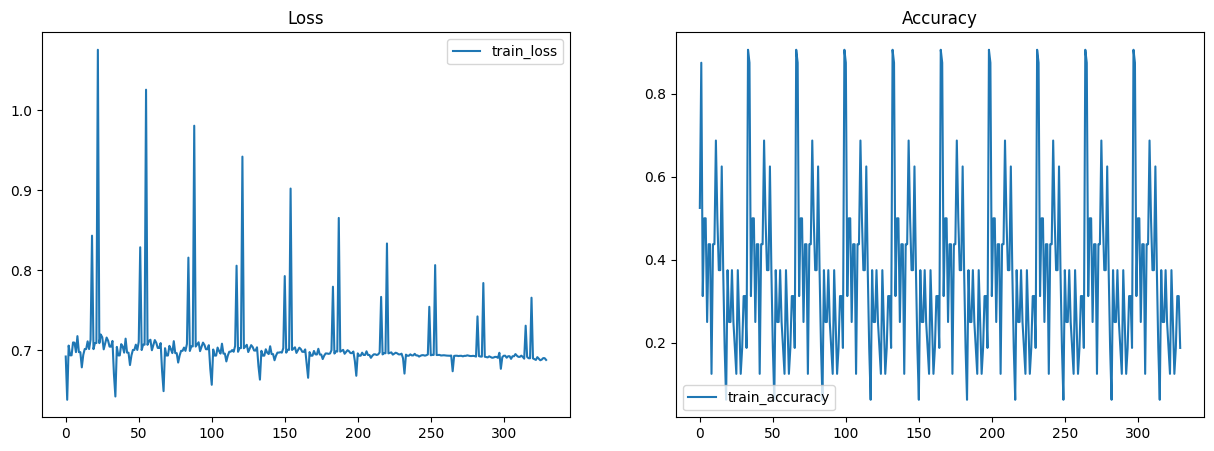

In [25]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train',):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

In [22]:
# TODO: Seguir implementando el resto de:
# https://flax.readthedocs.io/en/latest/nnx/mnist_tutorial.html#create-optimizer-and-metrics